In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util.data_loader import (load_dataset, split_train_validation, 
                              custom_random_oversampling, create_csv_submission,
                              change_negative_class)
from util.features_util import keep_features, merge_features
from util.features_info import FEATURES_DICT, REPLACEMENT_LIST
from util.preprocessing import preprocessing_pipeline, basic_preprocessing_pipeline
from util.train import reg_logistic_regression
from util.plotting import loss_visualization, decision_threshold
from util.evaluation import evaluation_summary
from util.predict import predict, predict_no_labels
from util.util import init_random_seeds


BASE_PATH = os.path.dirname(os.getcwd()) + "/data"

init_random_seeds()

# Data loading

### ⚠️ Note that the `x_sub` here refers to data for which predictions will be made, but for which we don't have the labels! To refer to the data used for local testing we'll use `x_va` and `y_va` (validation).

In [2]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(path_x_train=BASE_PATH + "/x_train.csv",
                                                      path_y_train=BASE_PATH + "/y_train.csv",
                                                      path_x_test=BASE_PATH + "/x_test.csv",
                                                      sub_sample=False)
# Create the feature index dictionary
feature_index = dict(zip(feature_names, range(len(feature_names))))

# Pre-processing

In [3]:
# Perform basic preprocessing on all the features
x_train_dirty_proc = basic_preprocessing_pipeline(x_train,
                                                  where=feature_names,
                                                  feature_index=feature_index,
                                                  normalization="min-max")


## Split local data into train and validation

#### From now on we'll use the local train and validation data: `x_tr` and `y_tr` for training and `x_va` and `y_va` for validation

In [4]:
# Translate labels from -1/1 to 0/1
y_train = change_negative_class(y_train[:, 1], current=-1, new=0)

# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_train_dirty_proc,
                                                  y_train,
                                                  valid_proportion=0.2)

## Data preparation for training

In [5]:
# NO oversampling

# Add bias column to the training and validation data
x_tr_bias = np.append(x_tr, np.ones(shape=(x_tr.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)


# Training

In [6]:
from util.train import reg_logistic_regression_hyperparameters
import pickle

lambdas_ = [0.0001, 0.001, 0.01]
gammas = [0.01, 0.05, 0.1, 0.5]
batch_sizes = [500, 5000, 10000]

hyperparameters = {
    "lambda_": lambdas_,
    "gamma": gammas,
    "batch_size": batch_sizes,
    "optimizer": ["sgd"]
}

In [7]:
res = reg_logistic_regression_hyperparameters(
    x_tr_bias,
    y_tr,
    x_va_bias,
    y_va,
    hyperparameters
)

Iteration 0/5000 -> lowest loss inf
Iteration 200/5000 -> lowest loss 4.768828902849514
Iteration 400/5000 -> lowest loss 3.291537678658295
Iteration 600/5000 -> lowest loss 2.2062495338337924
Iteration 800/5000 -> lowest loss 1.5144486990713066
Iteration 1000/5000 -> lowest loss 1.0835675731402243
Iteration 1200/5000 -> lowest loss 0.830203648848805
Iteration 1400/5000 -> lowest loss 0.6584615157896011
Iteration 1600/5000 -> lowest loss 0.5467678336016284
Iteration 1800/5000 -> lowest loss 0.4684735043850572
Iteration 2000/5000 -> lowest loss 0.4173058770656947
Iteration 2200/5000 -> lowest loss 0.38286696628327094
Iteration 2400/5000 -> lowest loss 0.3586129370519112
Iteration 2600/5000 -> lowest loss 0.34066929990290107
Iteration 2800/5000 -> lowest loss 0.32625818624669534
Iteration 3000/5000 -> lowest loss 0.31543189067738137
Iteration 3200/5000 -> lowest loss 0.30689956657584955
Iteration 3400/5000 -> lowest loss 0.29985352948301675
Iteration 3600/5000 -> lowest loss 0.2939148686

In [9]:
with open('res_shit_grid_search.pkl', 'wb') as f:
    pickle.dump(res, f)


## Load results

In [10]:
with open('res_shit_grid_search.pkl', 'rb') as f:
    res = pickle.load(f)

res[0].keys()

dict_keys(['lambda_', 'gamma', 'batch_size', 'optimizer', 'best_weights', 'train_loss', 'valid_loss'])

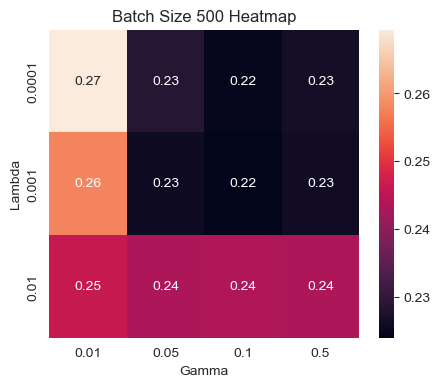

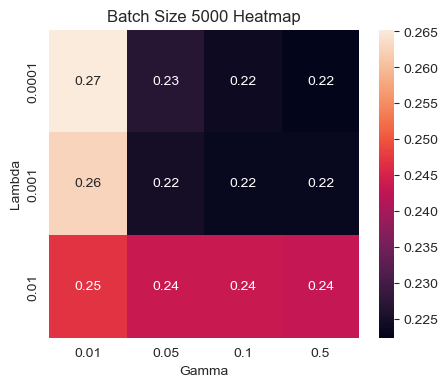

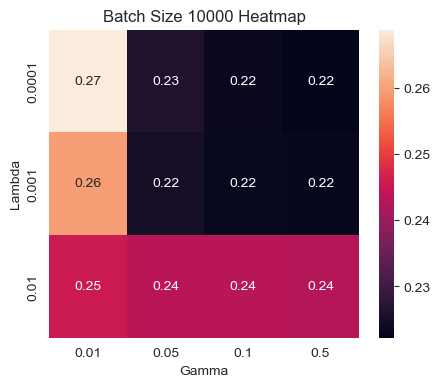

In [11]:
# Plot a heatmap for each batch size
for batch_size in batch_sizes:
    # Filter data for the current batch size
    filtered_res = [d for d in res if d['batch_size'] == batch_size]

    # Create a pivot table for the heatmap
    pivot_res = np.zeros((len(np.unique([d['lambda_'] for d in res])),
                           len(np.unique([d['gamma'] for d in res]))))
    for item in filtered_res:
        lambda_idx = np.where(np.unique([d['lambda_'] for d in res]) == item['lambda_'])[0][0]
        gamma_idx = np.where(np.unique([d['gamma'] for d in res]) == item['gamma'])[0][0]
        pivot_res[lambda_idx, gamma_idx] = item['valid_loss']

    # Create a heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(pivot_res, annot=True, xticklabels=np.unique([d['gamma'] for d in res]),
                yticklabels=np.unique([d['lambda_'] for d in res]))
    plt.xlabel('Gamma')
    plt.ylabel('Lambda')
    plt.title(f'Batch Size {batch_size} Heatmap')
    plt.savefig(os.path.dirname(os.getcwd()) + '/plots/' + f'heatmap_batch_size_{batch_size}_new.png')




## Evaluation on validation set

In [12]:
res.sort(key=lambda x: x["valid_loss"], reverse=False)
res_opt = res[0]
print("Optimal hyperparameters: gamma {}, lambda {}, batch size {}".format(res_opt["gamma"],
                                                                           res_opt["lambda_"],
                                                                           res_opt["batch_size"]))
print("Minimum validation loss: {}".format(res_opt["valid_loss"]))
w_opt = res_opt["best_weights"]

Optimal hyperparameters: gamma 0.5, lambda 0.0001, batch size 10000
Minimum validation loss: 0.2222250309346101


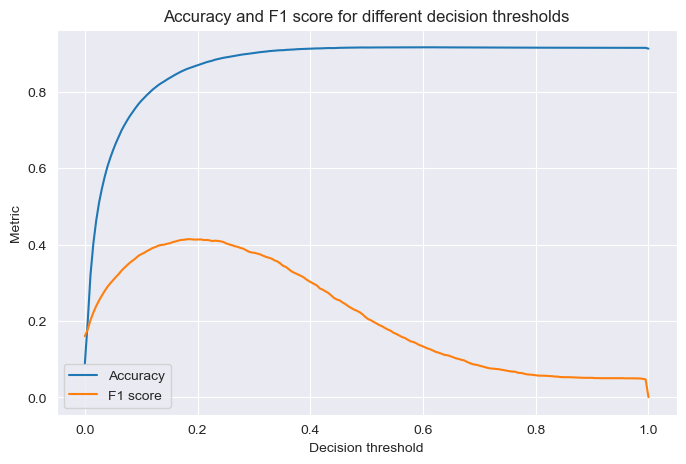

EVALUATION SUMMARY ON VALIDATION SET
Accuracy: 86.23%
Precision: 32.90%
Recall: 55.88%
F1-score: 41.41%
 -> optimal threshold: 0.18592964824120603


In [13]:
threshold_opt = decision_threshold(x_va_bias, w_opt, y_va)
predicted_y_va = predict(x_va_bias,
                         w_opt,
                         threshold=threshold_opt,
                         negative_label=0)
print("EVALUATION SUMMARY ON VALIDATION SET")
evaluation_summary(y_va, predicted_y_va)
print(" -> optimal threshold: {}".format(threshold_opt))

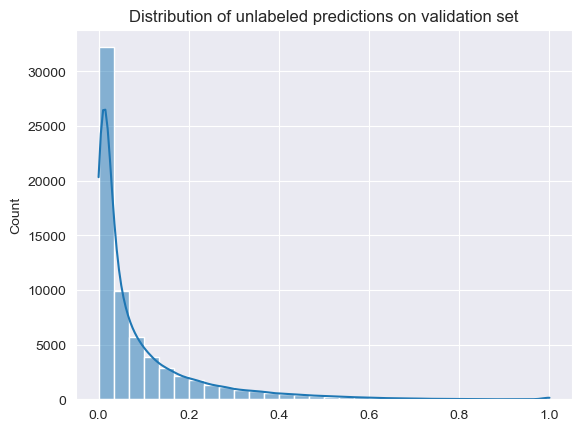

In [15]:
sns.histplot(predict_no_labels(x_va_bias, w_opt), bins=30, kde=True)
plt.title("Distribution of unlabeled predictions on validation set")
plt.show()


---

# COMPUTE RESULT FOR SUBMISSION

## Pre processing and data preparation

In [37]:
# Keeping only selected features both in train and validation set
ids = x_sub[:, 0]
x_sub_clean, clean_features, clean_feature_index = keep_features(x_sub,
                                                                 FEATURES_DICT.keys(),
                                                                 feature_names,
                                                                 feature_index,
                                                                 verbose=False)

In [38]:
# Call to the preprocessing pipeline both for submission set,
# but only on the set of clean features

x_sub_clean_proc = preprocessing_pipeline(x_sub_clean,
                                          where=clean_features,
                                          feature_index=clean_feature_index,
                                          nan_replacement=REPLACEMENT_LIST,
                                          normalize="mixed")

# Perform basic preprocessing on the rest of the features
x_sub_dirty_proc = basic_preprocessing_pipeline(x_sub,
                                                where=[f for f in feature_names if f not in clean_features],
                                                feature_index=feature_index,
                                                normalization="min-max")

x_sub_merged = merge_features(x_big=x_sub_dirty_proc,
                              feature_index_big=feature_index,
                              x_small=x_sub_clean_proc,
                              feature_index_small=clean_feature_index)

x_sub_bias = np.append(x_sub_merged,
                       np.ones(shape=(x_sub_merged.shape[0], 1)),
                       axis=1)

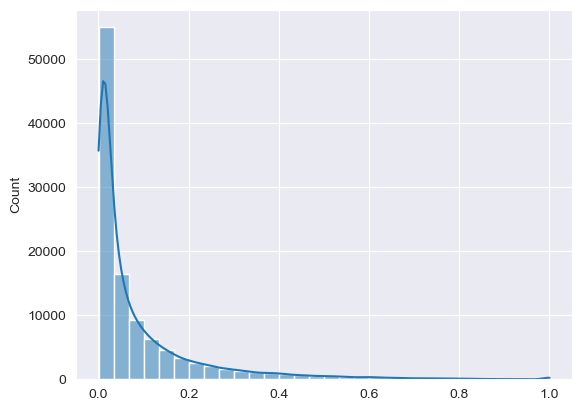

In [39]:
predicted_y_sub = predict(x_sub_bias,
                          w,
                          threshold=threshold_opt,
                          negative_label=-1)

sns.histplot(predict_no_labels(x_sub_bias, w), bins=30, kde=True)
plt.show()

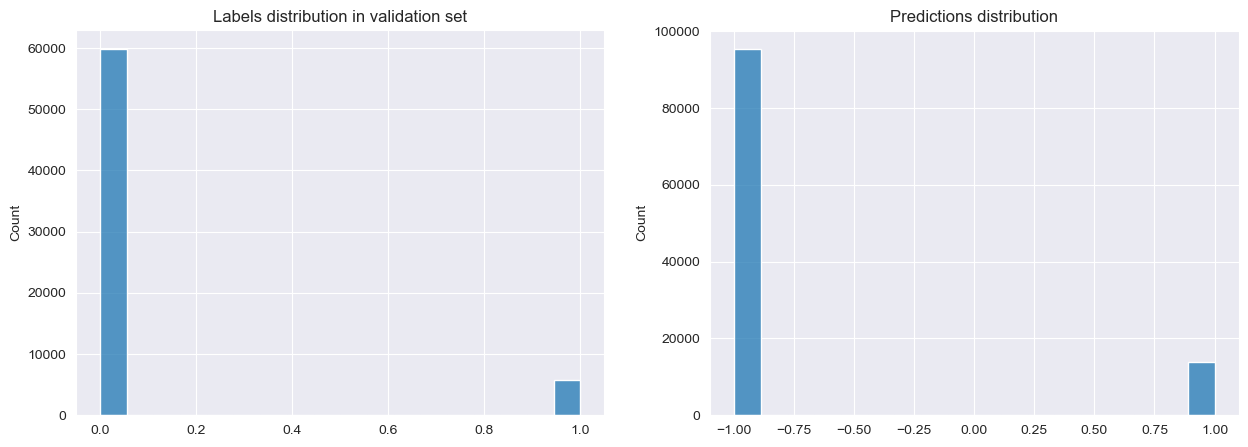

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_va, ax=axs[0])
axs[0].set_title("Labels distribution in validation set")
sns.histplot(predicted_y_sub, ax=axs[1])
axs[1].set_title("Predictions distribution")
plt.show()

In [18]:
# Save predictions to csv file
create_csv_submission(ids=ids, y_pred=predicted_y_sub, path=BASE_PATH + "/submission.csv")